In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")


In [34]:

# Load the dataset
data = pd.read_csv('train.csv') 

# Convert 'Date' column to datetime
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%d/%m/%Y')

# group by month
#data['Date'] = data['Order Date'].dt.to_period('M')
#preprocessed_data = data.groupby(['Date', 'Category'], as_index=False)['Sales'].sum()
#preprocessed_data = preprocessed_data[['Date', 'Category', 'Sales']]


# group by day
preprocessed_data = data.groupby(['Order Date', 'Category'], as_index=False)['Sales'].sum()

preprocessed_data = preprocessed_data[['Order Date', 'Category', 'Sales']]

# Display preprocessed data
#print(preprocessed_data.head())

# List of unique categories



In [35]:
def moving_average(category):
    category_data = preprocessed_data[preprocessed_data['Category'] == category]
    forecast_values = category_data['Sales'].rolling(window=5).mean()

    plt.figure(figsize=(12, 8))
    plt.scatter(category_data['Order Date'], category_data['Sales'], label=f"Actual Sales ('{category}')", color='black')
    plt.plot(category_data['Order Date'], forecast_values, label=f"Moving Average ('{category}')")
    plt.legend()
    plt.title(f'Moving Average Forecasting for {category}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()
    category_data['Sales']
    mse = mean_squared_error(category_data['Sales'].iloc[5:], forecast_values.iloc[5:])
    mae = mean_absolute_error(category_data['Sales'].iloc[5:], forecast_values.iloc[5:])
    mape = mean_absolute_percentage_error(category_data['Sales'].iloc[5:], forecast_values.iloc[5:])
    print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape}")
    return mse, mae, mape

def exponential_smoothing(category):
    category_data = preprocessed_data[preprocessed_data['Category'] == category]

    forecast_values = SimpleExpSmoothing(category_data['Sales']).fit(
        smoothing_level=0.2, optimized=False).fittedvalues
    
    plt.figure(figsize=(12, 8))
    plt.scatter(category_data['Order Date'], category_data['Sales'], label=f"Actual Sales ('{category}')", color='black')
    plt.plot(category_data['Order Date'], forecast_values, label=f"Exponential Smoothing ('{category}')", color = "red")
    plt.legend()
    plt.title(f'Exponential Smoothing Forecasting for {category}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

    mse = mean_squared_error(category_data['Sales'], forecast_values)
    mae = mean_absolute_error(category_data['Sales'], forecast_values)
    mape = mean_absolute_percentage_error(category_data['Sales'], forecast_values)
    print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape}")

    return mse, mae, mape

def linear_regression(category):
    category_data = preprocessed_data[preprocessed_data['Category'] == category]

    X = category_data['Order Date'].astype('int64').values.reshape(-1, 1)  # Using Order Date as the predictor
    y = category_data['Sales']
    
    model = LinearRegression().fit(X, y)
    forecast_values = model.predict(X)
    
    plt.figure(figsize=(12, 8))
    plt.scatter(category_data['Order Date'], category_data['Sales'], label=f"Actual Sales ('{category}')", color='black')
    plt.plot(category_data['Order Date'], forecast_values, label=f"Linear Regression ('{category}')", color='yellow')
    plt.legend()
    plt.title(f'Linear Regression Forecasting for {category}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

    mse = mean_squared_error(category_data['Sales'], forecast_values)
    mae = mean_absolute_error(category_data['Sales'], forecast_values)
    mape = mean_absolute_percentage_error(category_data['Sales'], forecast_values)
    print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape}")

    return mse, mae, mape

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset

def deseasonalized_linear_regression(category):
    category_data = preprocessed_data[preprocessed_data['Category'] == category]
    
    # Assuming data is already grouped by day within the month for monthly patterns
    # Group data by day and calculate the mean for each day
    category_data['Day'] = category_data['Order Date'].dt.day
    daily_means = category_data.groupby('Day')['Sales'].mean()
    
    # Repeat the daily mean to match the length of the dataset
    full_seasonal_pattern = category_data['Day'].map(daily_means)
    
    # Deseasonalize the data
    deseasonalized = category_data['Sales'] / full_seasonal_pattern
    
    # Fit linear regression to the deseasonalized data
    # Days since the first date in the dataset
    days_since_start = (category_data['Order Date'] - category_data['Order Date'].min()).dt.days
    X = days_since_start.values.reshape(-1, 1)  # Using days since start as the predictor
    y = deseasonalized.values
    model = LinearRegression().fit(X, y)
    
    # Forecast the next 30 days
    forecasted_sales = []
    last_date = category_data['Order Date'].iloc[-1]
    for day in range(1, 31):
        future_date = last_date + DateOffset(days=day)
        future_day_since_start = (future_date - category_data['Order Date'].min()).days
        deseasonalized_forecast = model.predict(np.array([[future_day_since_start]]))
        
        # Re-seasonalize the forecast value for each future day
        if future_date.day in daily_means.index:
            future_day_seasonal = daily_means[future_date.day]
        else:
            # If the seasonal pattern for that day isn't known, use the latest known seasonal pattern
            future_day_seasonal = daily_means.iloc[-1]
        
        forecasted_sales.append(deseasonalized_forecast[0] * future_day_seasonal)
    
    forecasted_sales = np.array(forecasted_sales)
    
    # Prepare the original and forecasted data for plotting
    forecast_dates = pd.date_range(start=last_date + DateOffset(days=1), periods=30)
    actual_dates = category_data['Order Date']
    all_dates = pd.concat([actual_dates, pd.Series(forecast_dates)]).reset_index(drop=True)

    actual_sales = category_data['Sales']
    all_sales = np.concatenate([actual_sales, forecasted_sales])

    plt.figure(figsize=(12, 8))
    # Plot only the forecasted sales for the next 30 days
    plt.plot(forecast_dates, forecasted_sales, label="Deseasonalized Linear Regression Forecast", color='green')
    plt.axvline(x=last_date, color='red', linestyle='--', label='Forecast Start Point')
    plt.legend()
    plt.title(f'Future 30-Day Sales Forecast for {category}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

    # Calculate performance metrics for the known data
    mse = mean_squared_error(actual_sales, all_sales[:len(actual_sales)])
    mae = mean_absolute_error(actual_sales, all_sales[:len(actual_sales)])
    mape = mean_absolute_percentage_error(actual_sales, all_sales[:len(actual_sales)])
    
    total_forecasted_sales = np.sum(forecasted_sales)
    print(f"Forecasted sales for the next 30 days: {forecasted_sales}")
    print(f"Total forecasted sales for the next 30 days: {total_forecasted_sales}")

    return mse, mae, mape

    ####################################################################################################################
    ####################################################################################################################
    ####################################################################################################################
    ####################################################################################################################

def holts_method(category):
    category_data = preprocessed_data[preprocessed_data['Category'] == category]

    # Fit Holt's Method
    model = ExponentialSmoothing(category_data['Sales'], trend='add').fit()
    forecast_values = model.fittedvalues
    
    plt.figure(figsize=(12, 8))
    plt.scatter(category_data['Order Date'], category_data['Sales'], label=f"Actual Sales ('{category}')", color='black')
    plt.plot(category_data['Order Date'], forecast_values, label=f"Holt's Method ('{category}')", color='orange')
    plt.legend()
    plt.title(f"Holt's Method Forecasting for {category}")
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

    mse = mean_squared_error(category_data['Sales'], forecast_values)
    mae = mean_absolute_error(category_data['Sales'], forecast_values)
    mape = mean_absolute_percentage_error(category_data['Sales'], forecast_values)
    print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape}")

    return mse, mae, mape

def winters_method(category):
    category_data = preprocessed_data[preprocessed_data['Category'] == category]

    # Fit Winter's Method
    model = ExponentialSmoothing(category_data['Sales'], trend='add', seasonal='add', seasonal_periods=30).fit()
    forecast_values = model.fittedvalues
    
    plt.figure(figsize=(12, 8))
    plt.scatter(category_data['Order Date'], category_data['Sales'], label=f"Actual Sales ('{category}')", color='black')
    plt.plot(category_data['Order Date'], forecast_values, label=f"Winter's Method ('{category}')", color='green')
    plt.legend()
    plt.title(f"Winter's Method Forecasting for {category}")
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

    mse = mean_squared_error(category_data['Sales'], forecast_values)
    mae = mean_absolute_error(category_data['Sales'], forecast_values)
    mape = mean_absolute_percentage_error(category_data['Sales'], forecast_values)
    print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape}")

    return mse, mae, mape

Category: Office Supplies


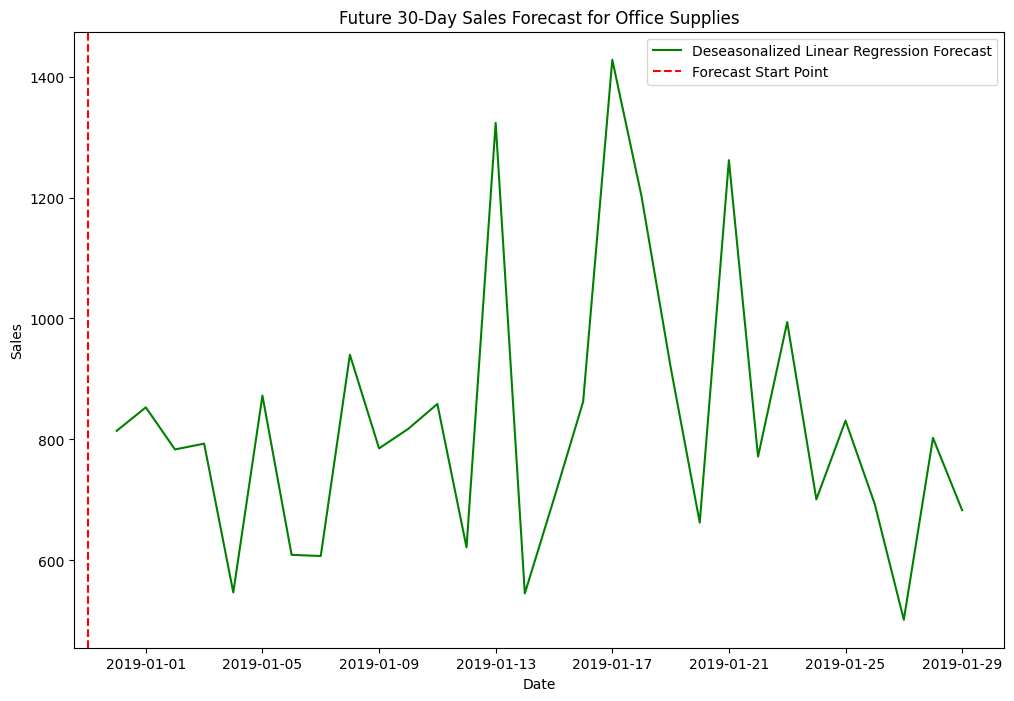

Forecasted sales for the next 30 days: [ 814.24707872  853.04199355  783.502715    793.06024843  546.96597331
  872.47272085  609.14777676  607.28431685  940.02206082  785.22369082
  817.47311638  858.68986641  621.57728312 1323.55233879  545.41663952
  702.05673366  862.34219602 1427.89804035 1202.75662364  920.0160594
  662.57802376 1261.81146271  771.73919016  994.02587424  700.870213
  831.05628767  693.63619651  501.91282541  802.56366271  683.0291252 ]
Total forecasted sales for the next 30 days: 24789.97033376465
Category: Furniture


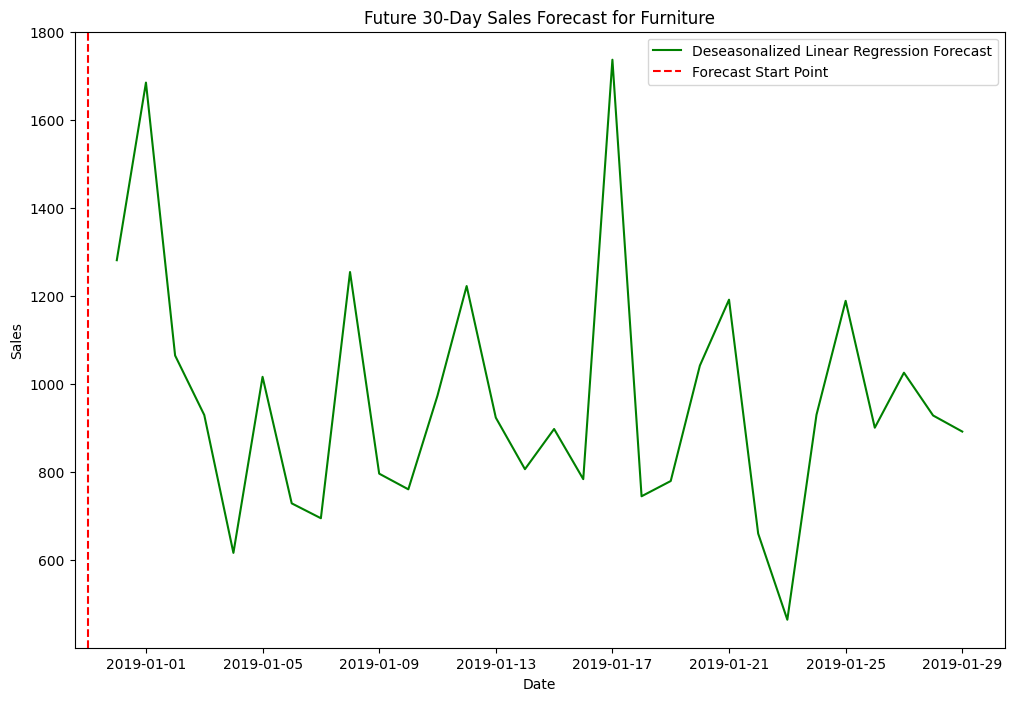

Forecasted sales for the next 30 days: [1281.81412147 1685.763105   1065.09186383  929.75070131  616.14069986
 1016.60503984  728.80477628  694.9842243  1254.90089444  796.37374714
  760.71660906  973.83502398 1223.03920435  923.78557479  806.55222209
  897.93406645  783.87619689 1737.76500453  744.94163592  779.60625816
 1042.12233771 1192.02610573  660.04408776  464.17577298  930.24439042
 1189.42933116  900.89032856 1025.95507244  928.64264713  892.11389779]
Total forecasted sales for the next 30 days: 28927.924941361554
Category: Technology


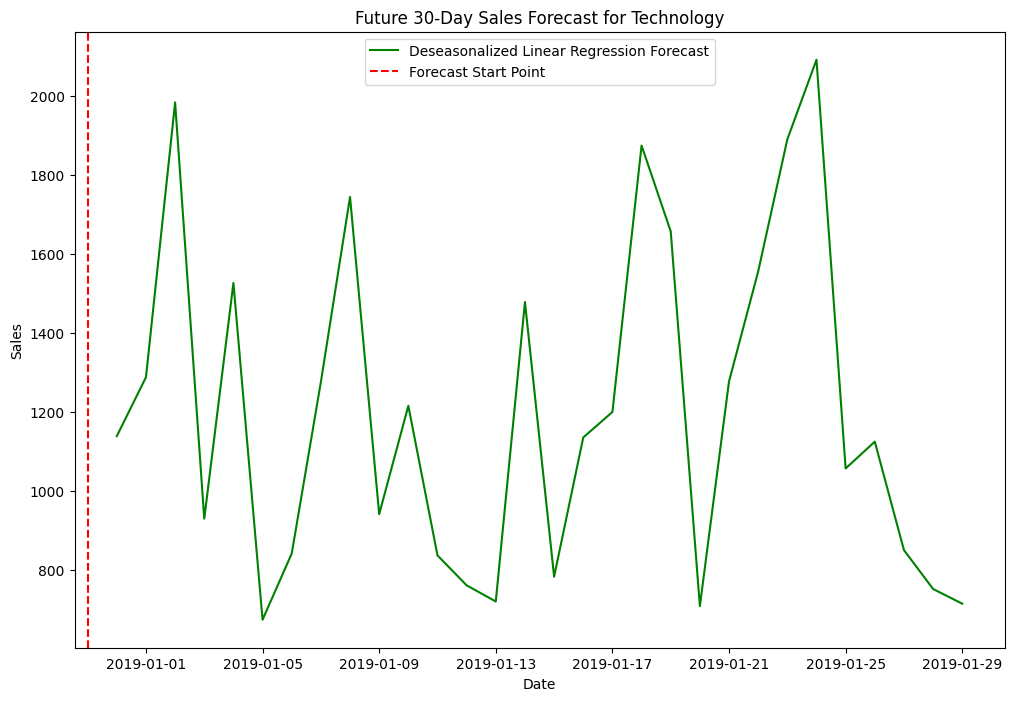

Forecasted sales for the next 30 days: [1138.41760648 1287.45008049 1983.69564474  929.40670169 1526.38275396
  673.41158719  840.92789462 1275.43741776 1744.25990458  940.76159983
 1215.27514213  836.28206393  760.49675198  719.61633707 1478.09379919
  782.5119115  1135.04047747 1199.6395313  1874.34375355 1657.01935619
  707.84018691 1276.97330139 1555.48248216 1890.11827241 2091.7850693
 1056.54817003 1124.35623072  849.71664318  751.24282399  714.02213805]
Total forecasted sales for the next 30 days: 36016.55563378136


,Category,Method,MSE,MAE,MAPE
0,Office Supplies,Deseasonalized Linear Regression,0.0,0.0,0.0
1,Furniture,Deseasonalized Linear Regression,0.0,0.0,0.0
2,Technology,Deseasonalized Linear Regression,0.0,0.0,0.0


In [36]:
categories = preprocessed_data['Category'].unique()
methods = {
    'Deseasonalized Linear Regression': deseasonalized_linear_regression,
}

performance_metrics = []

for category in categories:
    print(f'Category: {category}')
    for method_name, method_func in methods.items():
        mse, mae, mape = method_func(category)
        performance_metrics.append({
            'Category': category,
            'Method': method_name,
            'MSE': mse,
            'MAE': mae,
            'MAPE': mape
        })

performance_metrics = pd.DataFrame(performance_metrics)
performance_metrics